In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from PIL import Image
import torchvision.transforms.functional as tvf
import torchvision.utils as tvu
from torch import Tensor
import torchvision.transforms as tvt
import os
from tqdm import tqdm
import random

## Utils

In [2]:
# 将一个PIL图像Resize后并转换为Tensor
def resize2tensor(image: Image, size: int) -> Tensor:
    transform = tvt.Compose([
        tvt.Resize(size, interpolation=tvf.InterpolationMode.BICUBIC),
        tvt.ToTensor()
    ])
    return transform(image)


def show_images_tensor(images_per_row: int, images_tensor: Tensor, size=16):
    """
    展示图片
    :param images_per_row: 每行展示的图片数量
    :param images_tensor: B*C*W*H，每个元素取值范围在[-1,1]之间
    :return:
    """

    images_tensor = 0.5 + 0.5 * images_tensor
    # Create a grid of images using make_grid
    grid = tvu.make_grid(images_tensor, nrow=images_per_row, padding=2, normalize=False)

    # plot绘画需要W*H*C的图片，即通道在最后一维
    grid_np = grid.numpy().transpose((1, 2, 0))

    # Display the grid of images using matplotlib
    plt.figure(figsize=(size, size))
    plt.imshow(grid_np)
    plt.axis("off")
    plt.show()

## Dataset
要将图像转为值在[-1,1]之间的Tensor

In [3]:
class ImageDataset(Dataset):
    def __init__(self, img_size, img_folder, min_size, img_nums):
        super().__init__()
        self.all_img_names = sorted(os.listdir(img_folder))
        self.img_folder = img_folder
        
        self.img_names = []
        # 将低像素的图片过滤掉
        for img_name in self.all_img_names:
            if len(self.img_names) >= img_nums:
                break
            width, height = Image.open(os.path.join(self.img_folder, img_name)).size
            if width >= min_size and height >= min_size:
                self.img_names.append(img_name)

        self.input_transform = transforms.Compose([
            transforms.Resize((img_size, img_size),
                              interpolation=tvf.InterpolationMode.BICUBIC),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 使用imagenet的mean和std将值转化到[-1, 1]之间
        ])

    def __getitem__(self, item):
        img_name = self.all_img_names[item]
        img_path = os.path.join(self.img_folder, img_name)
        img = Image.open(img_path).convert('RGB')

        input_img = self.input_transform(img)

        return input_img

    def __len__(self):
        return len(self.img_names)

### Set parameters and load data

In [4]:
img_size = 32
img_folder = 'H:/dataset/anime face'
img_size_min = 32
img_nums = 20000

In [5]:
training_dataset = ImageDataset(img_size=img_size, img_folder=img_folder, min_size=img_size_min, img_nums=img_nums)
training_dataloader = DataLoader(training_dataset, batch_size=128, num_workers=0, drop_last=True)

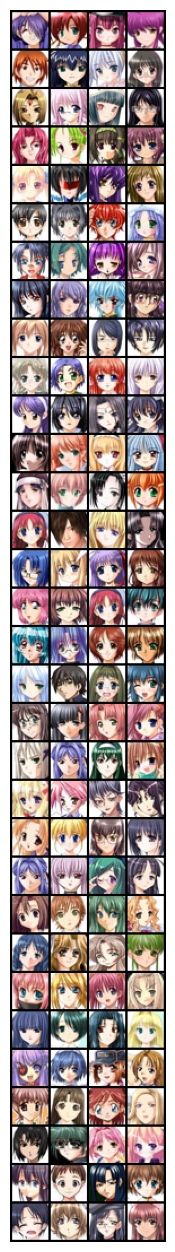

In [6]:
for input_images in training_dataloader:
    show_images_tensor(4, input_images)
    break

总步数n_steps=1000，$\beta\in[10^{-4},0.02]$且为线性间隔取值

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

n_steps = 1000
# 注意下标从0开始
first_element = torch.Tensor([0]).to(device)
beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
# 在首位添加元素0，这样time step就和下标一一对应
beta = torch.cat((first_element, beta))
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sigma = torch.sqrt(beta)

In [8]:
print('beta[0:10]:', beta[0:10])
print('alpha[0:10]:', alpha[0:10])
print('alpha_bar[0:10]', alpha_bar[0:10])
print('sigma[0:10]', sigma[0:10])

beta[0:10]: tensor([0.0000e+00, 1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04,
        1.9960e-04, 2.1952e-04, 2.3944e-04, 2.5936e-04], device='cuda:0')
alpha[0:10]: tensor([1.0000, 0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9998, 0.9998,
        0.9997], device='cuda:0')
alpha_bar[0:10] tensor([1.0000, 0.9999, 0.9998, 0.9996, 0.9995, 0.9993, 0.9991, 0.9989, 0.9986,
        0.9984], device='cuda:0')
sigma[0:10] tensor([0.0000, 0.0100, 0.0110, 0.0118, 0.0126, 0.0134, 0.0141, 0.0148, 0.0155,
        0.0161], device='cuda:0')


### Get $x_t$
$$\boldsymbol{x_t}=\sqrt{\bar{\alpha}_t}\boldsymbol{x_0}+\sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}$$
$$\boldsymbol{\epsilon}\sim N(0,I)$$
对于`get_xt_given_x0_and_t`，每次使用的$\boldsymbol{\epsilon}$是一样的，应该从外部传入

In [9]:
def get_xt_given_x0_and_t(x0, t, eps):
    """
    x0: (B, C, W, H)
    t: (B,)
    eps: (B, C, W, H)
    """
    sqrt_alpha_bar = torch.sqrt(alpha_bar[t]) # (B,)
    sqrt_alpha_bar = sqrt_alpha_bar.view(x0.shape[0], 1, 1, 1) # (B, 1, 1, 1) 为了沿着B轴和x0运算
    
    sqrt_one_minus_alpha_bar = torch.sqrt(1-sqrt_alpha_bar) # (B,)
    sqrt_one_minus_alpha_bar = sqrt_one_minus_alpha_bar.view(x0.shape[0], 1, 1, 1) # (B, 1, 1, 1) 为了沿着B轴和x0运算
    
    xt = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * eps
    
    return xt

### Sampling with trained model
$$\boldsymbol{x}_{t-1}=\frac{1}{\sqrt{\alpha_t}}(\boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}*\boldsymbol{\epsilon}_\theta(\boldsymbol{x}_t, t))+\sigma_t*\boldsymbol{z}$$
$$\boldsymbol{z}\sim N(0,I)$$

In [10]:
def get_x0_given_xt_and_t_and_model(xt, T, model):
    """
    xt: (B, C, W, H)
    T: (B,)
    eps_theta: (B, C, W, H)
    """
    B = xt.shape[0]
    for i in range(T):
        t = (torch.zeros(B) + T-i).long().to(device)
        
        eps_theta = model(xt, t) # (B, C, W, H)

        one_minus_alpha = (1 - alpha[t]).view(B, 1, 1, 1) # (B, 1, 1, 1)
        one_minus_alpha_bar = (1 - alpha_bar[t]).view(B, 1, 1, 1) # (B, 1, 1, 1)
        coef_eps_theta = one_minus_alpha / one_minus_alpha_bar # (B, 1, 1, 1)

        coef_mean = (1 / torch.sqrt(alpha[t])).view(B, 1, 1, 1) # (B, 1, 1, 1)

        mean = coef_mean * (xt - coef_eps_theta * eps_theta) # (B, C, W, H)

        z = torch.randn_like(xt) # (B, C, W, H)
        variance = sigma[t].view(B, 1, 1, 1) * z # (B, C, W, H)

        x_t = mean + variance # (B, C, W, H)
    
    return x_t # (B, C, W, H)

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self):
        super(PositionalEncoding, self).__init__()
        
    def forward(self, x, t):
        """
            x: (B, C, W, H)
            t: (B,)
        """
        t = t.view(x.shape[0], 1, 1, 1) # t: (B, 1, 1, 1)
        P = torch.sqrt(t/n_steps).to(x.device)
        x = x + P
        return x

In [12]:
class EpsilonPredictor(nn.Module):
    def __init__(self):
        super(EpsilonPredictor, self).__init__()
        # 卷积后的大小：output_size = (n + 2p - k) / s + 1
        # 转置卷积后的大小：output_size = (n - 1) * s - 2 * p + k + out_padding
        self.conv1 = nn.Conv2d(3, 5, 3, 1, 1)
        self.conv2 = nn.Conv2d(8, 13, 3, 1, 1)
        self.conv3 = nn.Conv2d(16, 3, 3, 1, 1)
        self.relu = nn.ReLU()
        
        
        self.positional_encoding = PositionalEncoding()
        
    def forward(self, x, t):
        """
            x: (B, C, W, H)
            t: (B,)
        """
        x = self.positional_encoding(x, t)
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(torch.cat((x, x1), dim=1)))
        x3 = self.conv3(torch.cat((x, x2), dim=1))
        
        return x3

### Train the model
$$\nabla_{\theta}\Vert \boldsymbol{\epsilon}-\boldsymbol{\epsilon}_{\theta}(x_t, t)\Vert^2$$

In [13]:
model = EpsilonPredictor().to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epoch_num = 200

model.train() # 开启训练模式！
for i in tqdm(range(epoch_num), desc='Training'):
    for input_images in training_dataloader:
        x0 = input_images.to(device) # (B, C, W, H)
        
        B = input_images.shape[0]
        t = torch.randint(1, n_steps, (B,)).to(device) # (B,)
        
        eps = torch.randn_like(x0) # (B, C, W, H)
        xt = get_xt_given_x0_and_t(x0, t, eps) # (B, C, W, H)
        
        eps_theta = model(xt, t)
        
        loss = criterion(eps_theta, eps)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    torch.save(model.state_dict(), "model_temp.pth")

Training: 100%|██████████| 200/200 [54:42<00:00, 16.41s/it]


In [14]:
print("Saving model...")
torch.save(model.state_dict(), "model.pth")

Saving model...


## Sampling

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


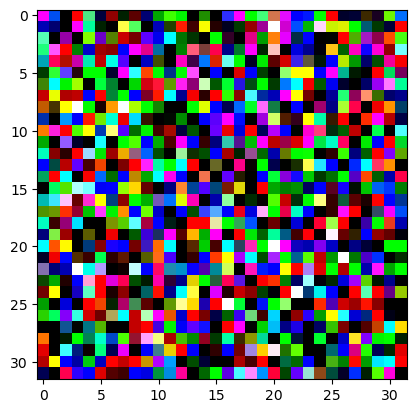

In [15]:
noise = torch.randn(1, 3, img_size, img_size).to(device)
noise_img = noise.view(3, img_size, img_size).permute(1, 2, 0).detach().cpu().numpy()

plt.imshow(noise_img)
plt.show()

In [16]:
model.eval() # 开启评估模式！
with torch.no_grad():
    sampling_results = get_x0_given_xt_and_t_and_model(noise, n_steps, model)

In [17]:
sampling_results = sampling_results.squeeze(0).detach().cpu()

In [18]:
sampling_results.shape

torch.Size([3, 32, 32])

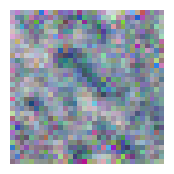

In [19]:
show_images_tensor(5, sampling_results, size=2)

In [20]:
sampling_results[0]

tensor([[ 0.3431,  0.4673,  0.1865,  ..., -0.0302,  0.0917,  0.2845],
        [ 0.5232, -0.2498, -0.2261,  ...,  0.0476,  0.0557,  0.2734],
        [ 0.5954,  0.2835, -0.2710,  ..., -0.0115, -0.1079,  0.4372],
        ...,
        [ 0.2123,  0.0625, -0.1738,  ...,  0.3459, -0.0412, -0.0560],
        [ 0.0797, -0.3896,  0.4135,  ...,  0.1696,  0.0097, -0.0354],
        [ 0.0655,  0.1863,  0.0542,  ...,  0.1415,  0.1763,  0.3380]])